In [30]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

import optuna

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [31]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

In [33]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
#quantity 이상치 튜플 (74315개 구매직후 환불한)2개 제거
data=data.drop([433791,433796])
# #price 이상치 튜플 (1000원짜리 60개사서 한번에 64300.5의 price로 환불한)2개 기록 제거
# data=data.drop([553676,553686])
#뒤의 색상 option 제거
data['product_id']=data['product_id'].astype(str).map(lambda x : x if x.isdigit() else x[:-1])

In [34]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')
        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

In [35]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=True):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres*1.1).astype(int) #임계값 1.1로 유연한 라벨링을 통한 성능향상

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

In [36]:
def plot_feature_importances(df, n=40, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    plt.show()
    plt.savefig("fi_fig.png")
    plt.close()
    return df

In [133]:
def feature_engineering1(df, year_month):
    df = df.copy()
    df2=df.copy()
    #customer_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()
    #product_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_product_id'] = df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_product_id'] = df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_product_id'] = df.groupby(['product_id'])['price'].cumsum()
    #order_id 기준으로 group by 후 total,quantity, price의 누적합 계산
    df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()
    
    #month, year_month 추가
    df['month']=df['order_date'].dt.month
    df['year_month']=df['order_date'].dt.strftime('%Y-%m')
    
    #description 마지막 단어로 요약
    df['desc_summary']=df['description'].map(lambda x :x.split()[-1])
    #diff feature 생성
    df['order_ts']=df['order_date'].astype(np.int64)
    df['order_ts_diff']=df.groupby(['customer_id'])['order_ts'].diff()
    df['quantity_diff']=df.groupby(['customer_id'])['quantity'].diff()
    df['price_diff']=df.groupby(['customer_id'])['price'].diff()
    df['total_diff']=df.groupby(['customer_id'])['total'].diff()
    
    #마지막이 환불인 기록 제거, 사람별로 last order 피처 생성
    df2=df2[~df2['order_id'].str.contains('C')]
    df['last_order_ts']=df2['order_date'].astype(np.int64)
    df['last_order_ts_diff']=df.groupby(['customer_id'])['last_order_ts'].diff()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    #percent over 300 피처 사람별로 생성, 
    train_po3=train.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    test_po3=test.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    train_po3['o3']=train_po3.agg({'total': lambda x :1 if x>300 else 0})
    test_po3['o3']=test_po3.agg({'total': lambda x :1 if x>300 else 0})
    # num_whole=po3.groupby(['customer_id'])['o3'].agg('count')
    tr_absolute_po3=round(train_po3.groupby(['customer_id'])['o3'].agg('mean'),2).values[:].squeeze()
    te_absolute_po3=round(test_po3.groupby(['customer_id'])['o3'].agg('mean'),2).values[:].squeeze()
    tr_num_one=train_po3.groupby(['customer_id'])['o3'].agg('sum')
    te_num_one=test_po3.groupby(['customer_id'])['o3'].agg('sum')
    tr_relative_po3=round(tr_num_one/24,2).values[:].squeeze()
    te_relative_po3=round(te_num_one/24,2).values[:].squeeze()
    
    #사용기간 구매금액의 평균
    tr_usage_total_mean=train_po3.groupby(['customer_id']).agg({'total': ['mean','max','min','sum','count','std','skew']})
    te_usage_total_mean=test_po3.groupby(['customer_id']).agg({'total': ['mean','max','min','sum','count','std','skew']})
    tr_usage_total_mean.columns=['ym-total-mean','ym-total-max','ym-total-min','ym-total-sum','ym-total-count','ym-total-std','ym-total-skew']
    te_usage_total_mean.columns=['ym-total-mean','ym-total-max','ym-total-min','ym-total-sum','ym-total-count','ym-total-std','ym-total-skew']
    tr_usage_total_mean['ym-total-std'].fillna(0.0, inplace=True) 
    tr_usage_total_mean['ym-total-skew'].fillna(0.0, inplace=True) 
    te_usage_total_mean['ym-total-std'].fillna(0.0, inplace=True) 
    te_usage_total_mean['ym-total-skew'].fillna(0.0, inplace=True) 
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    train_label['absolute_po300']=tr_absolute_po3
    train_label['relative_po300']=tr_relative_po3
    test_label['absolute_po300']=te_absolute_po3
    test_label['relative_po300']=te_relative_po3
    train_label=train_label.merge(tr_usage_total_mean,on='customer_id',how='left')
    test_label=test_label.merge(te_usage_total_mean,on='customer_id',how='left')
    print(train_label.head())
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
        'cumsum_total_by_cust_id': agg_func,
        'cumsum_quantity_by_cust_id': agg_func,
        'cumsum_price_by_cust_id': agg_func,
        'cumsum_total_by_product_id': agg_func,
        'cumsum_quantity_by_product_id': agg_func,
        'cumsum_price_by_product_id': agg_func,
        'cumsum_total_by_order_id': agg_func,
        'cumsum_quantity_by_order_id': agg_func,
        'cumsum_price_by_order_id': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
        'month' : [lambda x:x.value_counts().index[0]],
        'year_month':[lambda x:x.value_counts().index[0]],
        'desc_summary' : [lambda x:x.value_counts().index[0]],
        'order_ts' : ['first','last'],
        'order_ts_diff' : agg_func,
        'last_order_ts' : ['first','last'],
        'last_order_ts_diff' : agg_func,
        'quantity_diff' : agg_func,
        'price_diff' : agg_func,
        'total_diff' : agg_func,
    }
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                if type(stat) is str:
                    new_cols.append(f'{col}-{stat}')
                else:
                    new_cols.append(f'{col}-mode')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    #agg취한 값들이 feature가 된다
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')
    
    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [134]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    ####################MLFLOW###########################
    import mlflow
    HOST = "http://localhost"
    mlflow.set_tracking_uri(HOST+":6006/")
    mlflow.start_run()
    ####################MLFLOW###########################
    
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
    
    # 폴드별 피처 중요도 평균값 계산해서 저장 
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
#     #add fig to mlflow
#     n=40
#     color='blue'
#     figsize=(12,8)
    
#     fi = fi.sort_values('importance', ascending = False).reset_index(drop = True)
    
#     # 피처 중요도 정규화 및 누적 중요도 계산
#     fi['importance_normalized'] = fi['importance'] / fi['importance'].sum()
#     fi['cumulative_importance'] = np.cumsum(fi['importance_normalized'])
    
#     plt.rcParams['font.size'] = 12
#     plt.style.use('fivethirtyeight')
#     # 피처 중요도 순으로 n개까지 바플롯으로 그리기
#     fi.loc[:n, :].plot.barh(y='importance_normalized', 
#                             x='feature', color=color, 
#                             edgecolor='k', figsize=figsize,
#                             legend=False)

#     plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
#     plt.title(f'Top {n} Most Important Features', size=18)
#     plt.gca().invert_yaxis()
    
#     plt.savefig("fi_fig.png")
#     mlflow.log_artifact("fi_fig.png")
#     plt.close()
    ####################MLFLOW###########################
    mlflow.log_param("folds", folds)
    for k,v in model_params.items():
        mlflow.log_param(k, v)

    mlflow.log_metric("Mean AUC", score)
    mlflow.log_metric("OOF AUC", roc_auc_score(y, y_oof))
    mlflow.end_run()
    ####################MLFLOW###########################      
    
    
    return y_oof, test_preds, fi

In [135]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 원래 0.8 피처 샘플링 비율
    'bagging_fraction': 0.8, # 원래 0.8 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
}
##optuna로 찾은 하이퍼 파라미터, 성능부진으로 폐기
# model_params = {
#     'objective': 'binary', # 이진 분류
#     'boosting_type': 'gbdt',
#     'metric': 'auc', # 평가 지표 설정
#     'n_estimators': 10000, # 트리 개수
#     'early_stopping_rounds': 100,
#     'seed': SEED,
#     'verbose': -1,
#     'n_jobs': -1,
#     'num_leaves': 3,
#     'max_bin': 151,
#     'min_data_in_leaf': 20,
#     'feature_fraction': 0.4045749352846054,
#     'bagging_fraction': 0.5326346180893494,
#     'bagging_freq': 2,
#     'lambda_l1': 0.007833432686496016,
#     'lambda_l2': 0.00046386007655434795
# }

In [136]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

In [138]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

2011-11 - final label shape: (5722, 4)
2011-12 - final label shape: (5914, 4)
   customer_id year_month  label  absolute_po300  relative_po300  \
0        12346    2011-11      0            0.00            0.00   
1        12347    2011-11      0            1.00            0.29   
2        12348    2011-11      0            1.00            0.21   
3        12349    2011-11      1            0.75            0.12   
4        12350    2011-11      0            1.00            0.04   

   ym-total-mean  ym-total-max  ym-total-min  ym-total-sum  ym-total-count  \
0     -17.074200       187.275     -285.9285      -85.3710               5   
1    1107.081643      2135.628      631.1580     7749.5715               7   
2     666.402000      1473.120      366.5640     3332.0100               5   
3    1091.883375      2314.323      -39.8475     4367.5335               4   
4     551.760000       551.760      551.7600      551.7600               1   

   ym-total-std  ym-total-skew  
0    171.71

In [14]:
features

Index(['o3_x', 'o3_y', 'quantity-mean', 'quantity-max', 'quantity-min',
       'quantity-sum', 'quantity-count', 'quantity-std', 'quantity-skew',
       'price-mean',
       ...
       'price_diff-count', 'price_diff-std', 'price_diff-skew',
       'total_diff-mean', 'total_diff-max', 'total_diff-min', 'total_diff-sum',
       'total_diff-count', 'total_diff-std', 'total_diff-skew'],
      dtype='object', length=130)

In [ ]:
train.head()

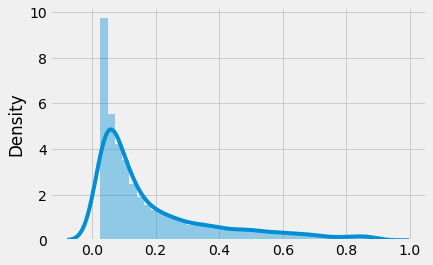

In [140]:
# features
sns.distplot(test_preds)
plt.show()

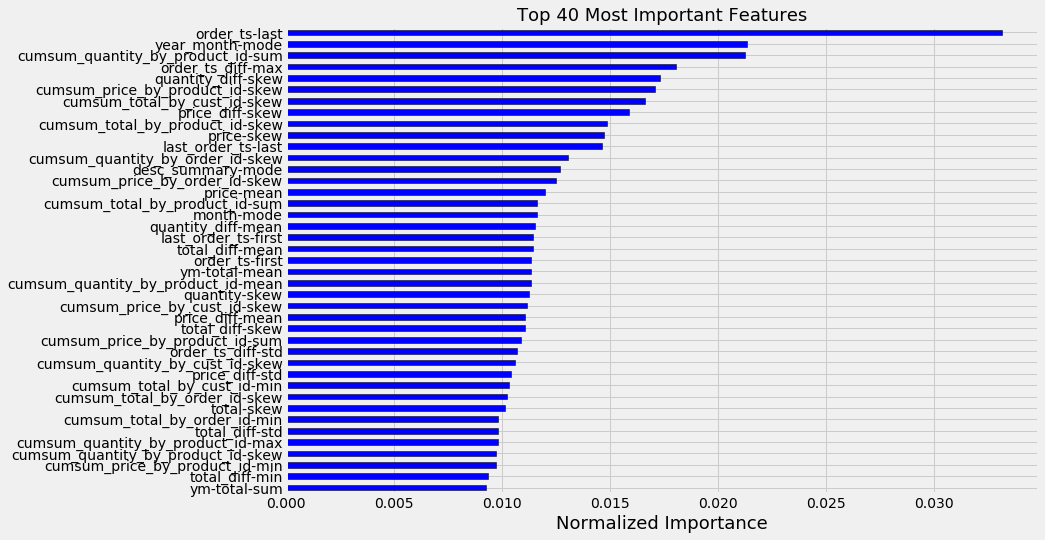

NameError: name 'mlflow' is not defined

<Figure size 432x288 with 0 Axes>

In [139]:
fi = plot_feature_importances(fi)

In [126]:
data_dir = '../input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '../model' # os.environ['SM_MODEL_DIR']
output_dir = '../output' # os.environ['SM_OUTPUT_DATA_DIR']
sub = pd.read_csv(data_dir + '/sample_submission.csv')
    
# 테스트 예측 결과 저장
sub['probability'] = test_preds


os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'try15-1.csv'), index=False)

In [ ]:
def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,    
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)
    
    return val_auc

In [ ]:
# import mlflow
# mlflow.end_run()
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100) # 10회 동안 하이퍼 파라미터 탐색
# study.best_params #가장 좋은 성능의 파라미터
# study.best_value #가장 좋은 성능
# study.trials_dataframe().sort_values(by='value', ascending=False) #파라미터에 따른 성능 출력

In [144]:
cat_params = {
    'n_estimators': 10000, # 트리 개수
    'learning_rate': 0.07, # 학습률
    'eval_metric': 'AUC', # 평가 지표 설정
    'loss_function': 'Logloss', # 손실 함수 설정
    'random_seed': SEED,
    'metric_period': 100,
    'od_wait': 100, # early stopping round
    'depth': 6, # 트리 최고 깊이
    'rsm': 0.8, # 피처 샘플링 비율
}

In [145]:
def make_cat_oof_prediction(train, y, test, features, categorical_features=None, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # CatBoost 모델 훈련
        clf = CatBoostClassifier(**model_params)
        clf.fit(x_tr, y_tr,
                eval_set=(x_val, y_val), # Validation 성능을 측정할 수 있도록 설정
                cat_features=categorical_features,
                use_best_model=True,
                verbose=True)
        
        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)[:,1]
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_
        
        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

In [146]:
y_oof, test_preds, fi_cat = make_cat_oof_prediction(train, y, test, features, model_params=cat_params)

fold: 1, x_tr.shape: (5149, 137), x_val.shape: (573, 137)
0:	test: 0.7399834	best: 0.7399834 (0)	total: 22.8ms	remaining: 3m 47s


100:	test: 0.8272655	best: 0.8288501 (69)	total: 924ms	remaining: 1m 30s
200:	test: 0.8232476	best: 0.8314344 (126)	total: 1.82s	remaining: 1m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8314343922
bestIteration = 126

Shrink model to first 127 iterations.
Fold 1 | AUC: 0.8314343922130839
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 137), x_val.shape: (573, 137)


0:	test: 0.8044405	best: 0.8044405 (0)	total: 21.1ms	remaining: 3m 30s
100:	test: 0.8328680	best: 0.8359051 (60)	total: 976ms	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8359050781
bestIteration = 60

Shrink model to first 61 iterations.
Fold 2 | AUC: 0.8359050780955255
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 137), x_val.shape: (572, 137)


0:	test: 0.7249548	best: 0.7249548 (0)	total: 16.7ms	remaining: 2m 47s
100:	test: 0.8319855	best: 0.8339073 (90)	total: 837ms	remaining: 1m 21s
200:	test: 0.8349919	best: 0.8352583 (193)	total: 1.7s	remaining: 1m 22s
300:	test: 0.8332414	best: 0.8358862 (205)	total: 2.51s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8358862144
bestIteration = 205

Shrink model to first 206 iterations.
Fold 3 | AUC: 0.835886214442013
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 137), x_val.shape: (572, 137)


0:	test: 0.7618685	best: 0.7618685 (0)	total: 17.8ms	remaining: 2m 57s
100:	test: 0.7693464	best: 0.7718010 (33)	total: 968ms	remaining: 1m 34s
200:	test: 0.7688897	best: 0.7731139 (115)	total: 1.76s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7731138807
bestIteration = 115

Shrink model to first 116 iterations.
Fold 4 | AUC: 0.7731138806964133
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 137), x_val.shape: (572, 137)
0:	test: 0.8115117	best: 0.8115117 (0)	total: 17.2ms	remaining: 2m 51s


100:	test: 0.8336790	best: 0.8351061 (80)	total: 957ms	remaining: 1m 33s
200:	test: 0.8374655	best: 0.8391590 (188)	total: 1.8s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8391589763
bestIteration = 188

Shrink model to first 189 iterations.
Fold 5 | AUC: 0.8391589763105318
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 137), x_val.shape: (572, 137)


0:	test: 0.7989725	best: 0.7989725 (0)	total: 20.2ms	remaining: 3m 21s
100:	test: 0.8462753	best: 0.8462753 (100)	total: 942ms	remaining: 1m 32s
200:	test: 0.8438969	best: 0.8467510 (125)	total: 1.76s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8467510227
bestIteration = 125

Shrink model to first 126 iterations.
Fold 6 | AUC: 0.8467510227380839
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 137), x_val.shape: (572, 137)
0:	test: 0.8005233	best: 0.8005233 (0)	total: 18.8ms	remaining: 3m 8s


100:	test: 0.8439540	best: 0.8477595 (78)	total: 927ms	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8477594901
bestIteration = 78

Shrink model to first 79 iterations.
Fold 7 | AUC: 0.8477594900580344
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 137), x_val.shape: (572, 137)
0:	test: 0.7591571	best: 0.7591571 (0)	total: 17.5ms	remaining: 2m 54s


100:	test: 0.8375036	best: 0.8440301 (44)	total: 926ms	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8440300637
bestIteration = 44

Shrink model to first 45 iterations.
Fold 8 | AUC: 0.8440300637427457
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 137), x_val.shape: (572, 137)


0:	test: 0.7805222	best: 0.7805222 (0)	total: 24.7ms	remaining: 4m 6s
100:	test: 0.8009301	best: 0.8042385 (81)	total: 937ms	remaining: 1m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8042385057
bestIteration = 81

Shrink model to first 82 iterations.
Fold 9 | AUC: 0.8042385057471265
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 137), x_val.shape: (572, 137)


0:	test: 0.7995879	best: 0.7995879 (0)	total: 20.5ms	remaining: 3m 25s
100:	test: 0.8420675	best: 0.8449977 (78)	total: 962ms	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8449977314
bestIteration = 78

Shrink model to first 79 iterations.
Fold 10 | AUC: 0.8449977313974592
--------------------------------------------------------------------------------

Mean AUC = 0.8303275355441017
OOF AUC = 0.8288208682508414


In [147]:
data_dir = '../input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '../model' # os.environ['SM_MODEL_DIR']
output_dir = '../output' # os.environ['SM_OUTPUT_DATA_DIR']
sub = pd.read_csv(data_dir + '/sample_submission.csv')
    
# 테스트 예측 결과 저장
sub['probability'] = test_preds


os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'try16_cat.csv'), index=False)

In [148]:
xgb_params = {
    'objective': 'binary:logistic', # 이진 분류
    'learning_rate': 0.1, # 학습률
    'max_depth': 6, # 트리 최고 깊이
    'colsample_bytree': 0.8, # 피처 샘플링 비율
    'subsample': 0.6, # 데이터 샘플링 비율
    'eval_metric': 'auc', # 평가 지표 설정
    'seed': SEED,
} 

In [149]:
def make_xgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # XGBoost 데이터셋 선언
        dtrain = xgb.DMatrix(x_tr, label=y_tr)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        
        # XGBoost 모델 훈련
        clf = xgb.train(
            model_params,
            dtrain,
            num_boost_round=10000, # 트리 개수
            evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=200,
            early_stopping_rounds=100
        )
        
        # Validation 데이터 예측
        val_preds = clf.predict(dvalid)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(xgb.DMatrix(x_test)) / folds

        # 폴드별 피처 중요도 저장
        fi_tmp = pd.DataFrame.from_records([clf.get_score()]).T.reset_index()
        fi_tmp.columns = ['feature',f'fold_{fold+1}']
        fi = pd.merge(fi, fi_tmp, on='feature')

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

In [150]:
y_oof, test_preds, fi_xgb = make_xgb_oof_prediction(train, y, test, features, model_params=xgb_params)

fold: 1, x_tr.shape: (5149, 137), x_val.shape: (573, 137)
[0]	train-auc:0.80350	valid-auc:0.74406
[124]	train-auc:0.99990	valid-auc:0.80105
Fold 1 | AUC: 0.8010450464045876
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 137), x_val.shape: (573, 137)
[0]	train-auc:0.83712	valid-auc:0.76033
[173]	train-auc:1.00000	valid-auc:0.81149
Fold 2 | AUC: 0.811495510450464
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 137), x_val.shape: (572, 137)
[0]	train-auc:0.82695	valid-auc:0.75418
[168]	train-auc:1.00000	valid-auc:0.80984
Fold 3 | AUC: 0.8098373132908381
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 137), x_val.shape: (572, 137)
[0]	train-auc:0.84008	valid-auc:0.71532
[176]	train-auc:1.00000	valid-auc:0.76242
Fold 4 | AUC: 0.7625915707354199
------------------------------------------------------------------

In [151]:
data_dir = '../input' # os.environ['SM_CHANNEL_TRAIN']
model_dir = '../model' # os.environ['SM_MODEL_DIR']
output_dir = '../output' # os.environ['SM_OUTPUT_DATA_DIR']
sub = pd.read_csv(data_dir + '/sample_submission.csv')
    
# 테스트 예측 결과 저장
sub['probability'] = test_preds


os.makedirs(output_dir, exist_ok=True)
# 제출 파일 쓰기
sub.to_csv(os.path.join(output_dir , 'try16_xgb.csv'), index=False)